In [2]:
import numpy as np
import pandas as pd
from numpy.random import normal, multivariate_normal

import itertools
import hdbscan

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import DBSCAN
from scipy import stats


DATA_DIRECTORY = "C:\\Users\\WDAmo\\GitHub\\font_analysis\\data"
PARAM_LABELS = ["unit", "pen", "cap", "bar", "asc", "desc", "xht", "horz",
                "vert", "cont", "supr", "slnt", "aprt", "crnr", "over", "tapr"]
PARAM_NAMES = ["Unit Width", "Pen Width", "Cap Height", "Bar Height", "Ascender Height", "Descender Height", "X-Height",
              "Horizontal Increase", "Vertical Increase", "Contrast", "Superness", "Slanting", "Aperture", "Corner",
              "Overshoot", "Taper"]

def extract_data(lin, chain):
    raw_file = pd.read_csv(DATA_DIRECTORY + "\\" + str(lin) + "\\" + str(chain) + ".csv")["chosen.values"]
    df = pd.DataFrame([x[1:-1].split(',') for x in raw_file])
    return df
def extract_all():
    out = []
    for i in range(4): ##For each lineage,
        lin = []
        for j in range(4): ##And each chain inside that lineage
            lin.append(extract_data(i,j))
        out.append(lin)
    return out;
def split_df(df):
    if len(df) % 2 != 0:  # Handling `df` with `odd` number of rows
        df = df.iloc[:-1, :]
    df1, df2 =  np.array_split(df, 2)
    return df1, df2
def split_all(dfs): # Returns the second half of each dataframe, cast correctly
    out = []
    for i in range(4): ##For each lineage,
        lin = []
        for j in range(4): ##And each chain inside that lineage
            upper, lower = split_df(dfs[i][j])
            lin.append(lower.astype('float64').to_numpy())
        out.append(lin)
    return out;
def combine_all(chains):
    full_chain = np.empty((0,16), 'float64')
    for i in range(4):
        for j in range(4):
            full_chain = np.concatenate((full_chain, chains[i][j]))
    return full_chain
def combine_by_font(chains):
    arial = np.empty((0,16), 'float64')
    georgia = np.empty((0,16), 'float64')
    for i in range(4):
        if(i%2==1):
            for j in range(4):
                arial = np.concatenate((arial, chains[i][j]))
        else:            
            for j in range(4):
                georgia = np.concatenate((georgia, chains[i][j]))
    return arial, georgia
def add_noise(dfs, sigma):
    out = []
    noise = np.random.normal(0, sigma, dfs.shape)  
    return (dfs + noise)

raw_data = split_all(extract_all())
dataset = add_noise(combine_all(raw_data), 1)
arial, georgia = combine_by_font(raw_data)

In [7]:
df = pd.DataFrame(dataset, columns = PARAM_LABELS)
df

,unit,pen,cap,bar,asc,desc,xht,horz,vert,cont,supr,slnt,aprt,crnr,over,tapr
0,38.599774,87.795632,29.901754,69.845861,80.288053,81.094428,95.488269,43.944828,82.006180,90.382375,44.559009,62.581180,78.333439,59.220387,13.606693,28.309306
1,39.419237,85.108264,29.836398,70.714541,81.115137,82.695382,95.005447,44.931894,83.100672,90.194185,42.989549,61.381078,79.856613,57.319486,11.401741,29.160600
2,29.595920,81.514490,28.107000,63.503942,70.789961,82.406655,96.212966,45.115509,61.983598,80.226811,39.696905,62.568279,81.028354,50.532801,21.384896,21.805394
3,29.358599,82.294785,28.296055,63.952341,70.852658,81.566983,95.142172,46.326446,62.190062,80.130495,42.053569,60.181430,79.318455,50.228970,20.040911,22.104567
4,30.539734,81.044919,27.502472,63.449314,70.159190,81.874552,93.732422,46.482352,63.167993,80.484622,40.324278,62.679596,79.527813,50.259361,18.635178,22.854277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34905,31.759585,82.280549,78.889057,62.733535,67.917190,52.986154,40.307667,65.885802,52.955467,51.069835,23.383908,28.581105,69.012786,73.365487,98.394363,81.209089
34906,32.119859,81.644195,74.691353,63.451276,66.929460,53.498575,38.271375,66.351005,53.465047,51.581996,26.701823,30.758320,68.200222,75.572877,97.498916,80.093979
34907,33.482383,82.724747,76.485145,62.544667,67.157902,54.113209,43.214524,66.042452,53.291200,51.858734,24.339927,28.679842,68.271718,71.916413,98.292615,82.183572
34908,31.350504,82.010558,76.667097,62.480561,68.884874,55.009740,40.357967,63.882385,54.911772,52.158979,23.237538,28.930998,68.010288,72.931007,100.057926,83.627140


In [24]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=950, min_samples=5)
clusterer.fit(df)
unique_elements, counts_elements = np.unique(clusterer.labels_, return_counts=True)
print(counts_elements)

[ 1106   963  1222  2407 29212]


In [21]:
labels = clusterer.labels_
x = dataset
def pull_cluster_mean(id):
    bool_arr = labels == id
    return np.round(np.mean(x[bool_arr,:], axis=0))
pull_cluster_mean(0)

array([57., 45., 57., 39., 65., 43., 61., 21., 70., 54., 60., 59., 43.,
       64., 35., 24.])

In [23]:
def load_font(arr, filename):#List of values -> URL
    rounded = np.around(arr)
    out = "localhost:1999/font/"+filename+"/"
    for i in arr:
        out+= str(i)[:2] + "-"
    return out[:-1]+"/"
best = [2,1,0]
for i in best:
    print(load_font(list(pull_cluster_mean(i)), "hdb"+str(i)))

localhost:1999/font/hdb2/46-61-48-47-54-51-50-47-43-49-39-56-48-49-45-44/
localhost:1999/font/hdb1/41-54-44-50-41-61-57-67-56-60-52-47-82-52-51-40/
localhost:1999/font/hdb0/57-45-57-39-65-43-61-21-70-54-60-59-43-64-35-24/


In [11]:
min_clusters = np.arange(50,1600,100)
scores = []
for i in min_clusters:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=int(i), min_samples=5)
    clusterer.fit(df)
    unique_elements, counts_elements = np.unique(clusterer.labels_, return_counts=True)
    pct = (np.where(clusterer.probabilities_ < 0.05)[0].size)/dataset.shape[0]
    scores.append(pct)
    print(str(i)+": "+str(unique_elements.size - 1) +" clusters with score= "+ str(scores[-1]))

50: 318 clusters with score= 0.08387281581208823
150: 101 clusters with score= 0.09289601833285592
250: 67 clusters with score= 0.08224004583213979
350: 46 clusters with score= 0.14471498138069322
450: 34 clusters with score= 0.17742767115439703
550: 27 clusters with score= 0.2349756516757376
650: 24 clusters with score= 0.23211114293898596
750: 15 clusters with score= 0.2476940704669149
850: 12 clusters with score= 0.26617015181896303
950: 4 clusters with score= 0.031681466628473216
1050: 3 clusters with score= 0.05926668576339158
1150: 3 clusters with score= 0.05926668576339158
1250: 2 clusters with score= 0.09427098252649671
1350: 2 clusters with score= 0.09427098252649671
1450: 2 clusters with score= 0.09427098252649671
1550: 2 clusters with score= 0.09427098252649671


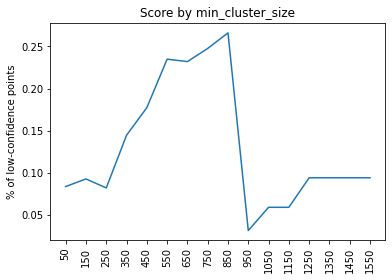

In [12]:
#This is disgusting
labels = np.array2string(min_clusters, precision=2, separator=' ')[3:-1].replace("\n","").replace("  "," ").split(" ")
x = np.arange(len(labels))
y = scores
fig, ax = plt.subplots()
line_1 = ax.plot(x, y)
ax.set_title("Score by min_cluster_size")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("% of low-confidence points")
plt.savefig("clustersize.pdf")
